In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rooth_path = '../data/'
generator_train = pd.read_csv(rooth_path + 'generator_train.csv')
gen_bear_train = pd.read_csv(rooth_path + 'gen_bear_train.csv')
transformer_train = pd.read_csv(rooth_path + 'transformer_train.csv')
hydraulic_train = pd.read_csv(rooth_path + 'hydraulic_train.csv')
gearbox_train = pd.read_csv(rooth_path + 'gearbox_train.csv')
logs_gen_train = pd.read_csv(rooth_path + 'logs_gen_train.csv')
logs_bear_train = pd.read_csv(rooth_path + 'logs_gen_bear_train.csv')
logs_transf_train = pd.read_csv(rooth_path + 'logs_transformer_train.csv')
logs_hyd_train = pd.read_csv(rooth_path + 'logs_hydraulic_train.csv')
logs_gear_train = pd.read_csv(rooth_path + 'logs_gearbox_train.csv')
logs_df = pd.read_csv(rooth_path + 'training/' + 'wind-farm-1-logs-training.csv')
failures_df = pd.read_csv(rooth_path + 'training/' + 'wind-farm-1-failures-training.csv')

In [3]:
generator_train['Date'] = pd.to_datetime(generator_train['Date'])
gen_bear_train['Date'] = pd.to_datetime(gen_bear_train['Date'])
transformer_train['Date'] = pd.to_datetime(transformer_train['Date'])
hydraulic_train['Date'] = pd.to_datetime(hydraulic_train['Date'])
gearbox_train['Date'] = pd.to_datetime(gearbox_train['Date'])

#### Do some exploratory data analysis

- Let's start with the logs df to see if we can find any correlation for the abnormal behaviour of the turbines (maybe we can add it to the actual datasets)
- Then let's explore each of the components dataframes

### Analysis on Logs
Note: It should be better to gain some knowledge within some people in the area to explain which logs explain abnormal behaviour

In [4]:
logs_df['TimeDetected'] = pd.to_datetime(logs_df['TimeDetected'])
failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])

In [5]:
# Sort by UnitTitle and TimeDetected
logs_df.sort_values(by=['UnitTitle', 'TimeDetected'], inplace=True)
logs_df.drop(columns=['UnitTitleDestination'], inplace=True)

In [6]:
# See how many different messages do we have
logs_df['Remark'].nunique()

5051

In [7]:
logs_df.head()

TimeDetected TimeReset UnitTitle                      Remark
3  2016-01-01 00:15:27+00:00       NaN       T01              Generator 1 in
4  2016-01-01 00:15:44+00:00       NaN       T01  External power ref.:2000kW
10 2016-01-01 00:45:43+00:00       NaN       T01  External power ref.:2000kW
15 2016-01-01 01:15:43+00:00       NaN       T01  External power ref.:2000kW
20 2016-01-01 01:45:43+00:00       NaN       T01  External power ref.:2000kW

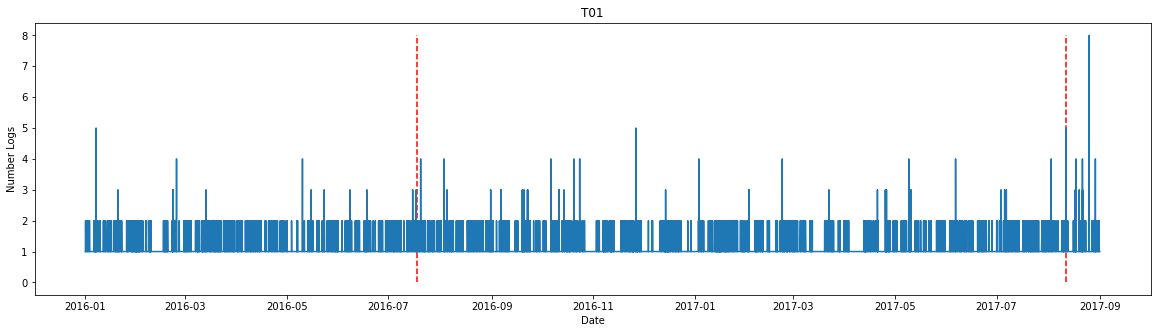

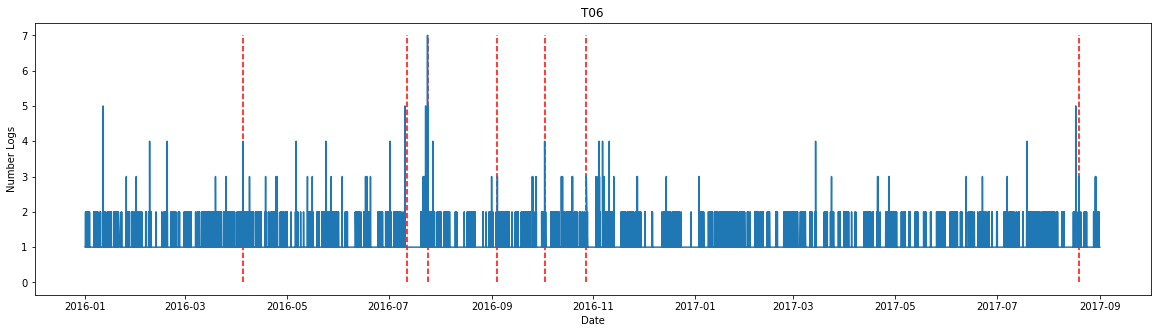

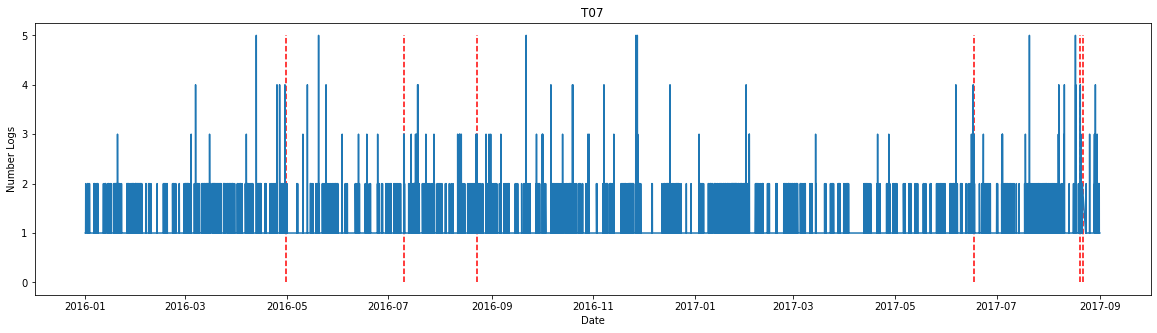

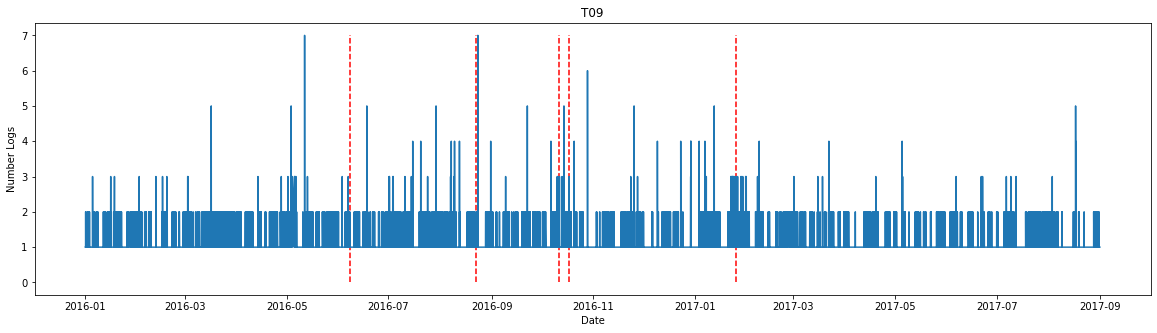

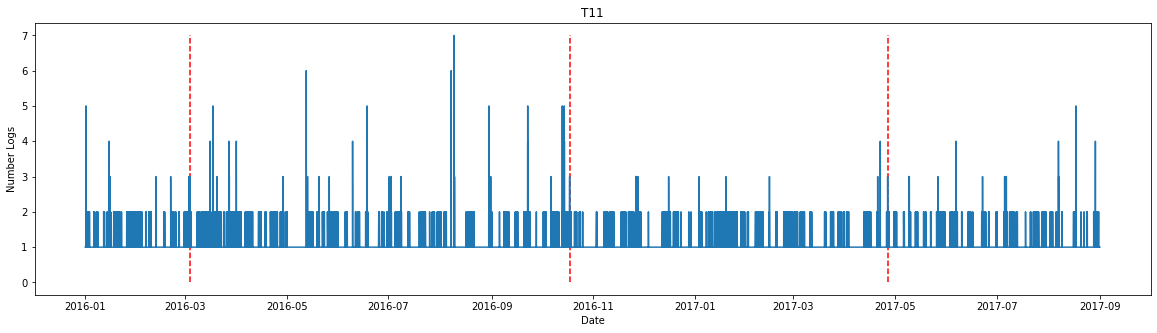

In [8]:
# We can't know which logs are malfuntion logs or normal behaviour logs
# See if there is an evident increase of nº logs before the failures
turbines = ['T01', 'T06', 'T07', 'T09', 'T11']
temp = logs_df.groupby(by=['UnitTitle', 'TimeDetected']).count().reset_index()
for turbine in turbines:
    plt.figure(figsize=(20,5)) 
    temp_ = temp[temp['UnitTitle']==turbine]
    failures_df_ = failures_df[failures_df['Turbine_ID']==turbine]
    plt.plot(temp_['TimeDetected'], temp_['Remark'])
    plt.vlines(x=failures_df_['Timestamp'], color='red', linestyle= '--', ymin=0, ymax=max(temp_['Remark']))
    plt.title(turbine)
    plt.xlabel("Date")
    plt.ylabel("Number Logs")
    plt.show()

##### We can't really see a clear relation between the increasing number of logs 2 months before a turbine failure. It should be interesting to know what logs are error logs, but we don't have an expert nearby

In [9]:
# See how many "error" messages we have in the logs_df
print(logs_df['Remark'].str.contains('rror').sum())

176


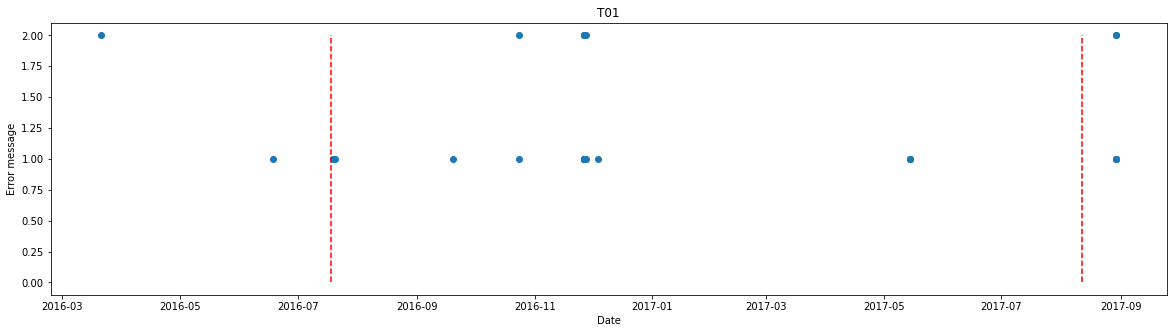

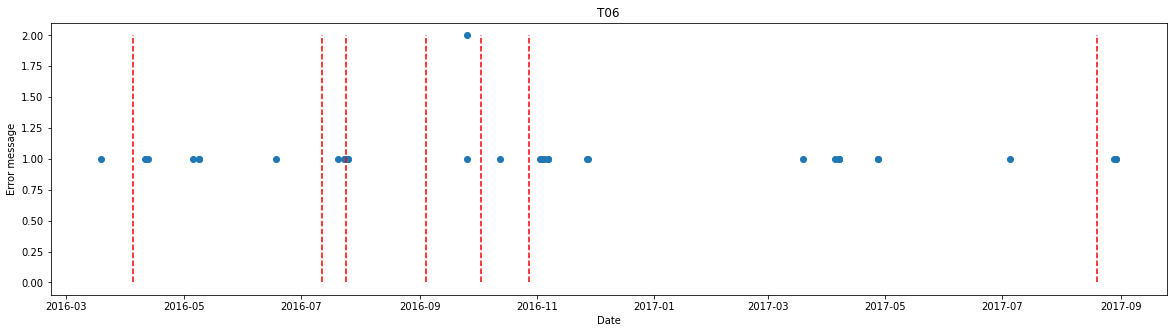

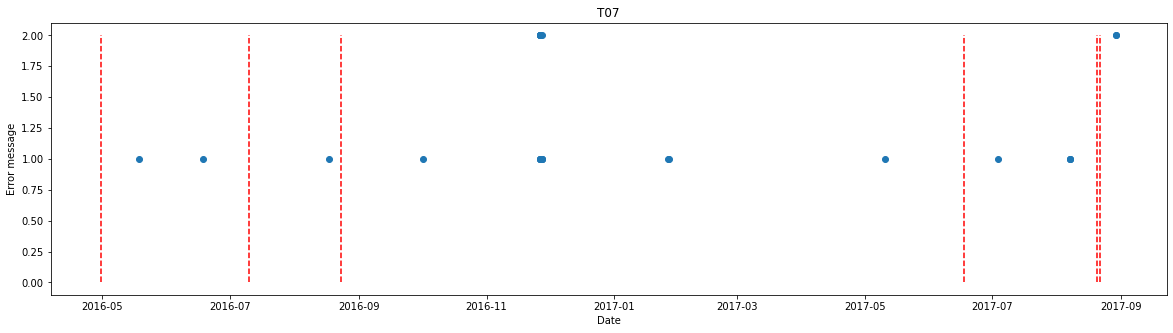

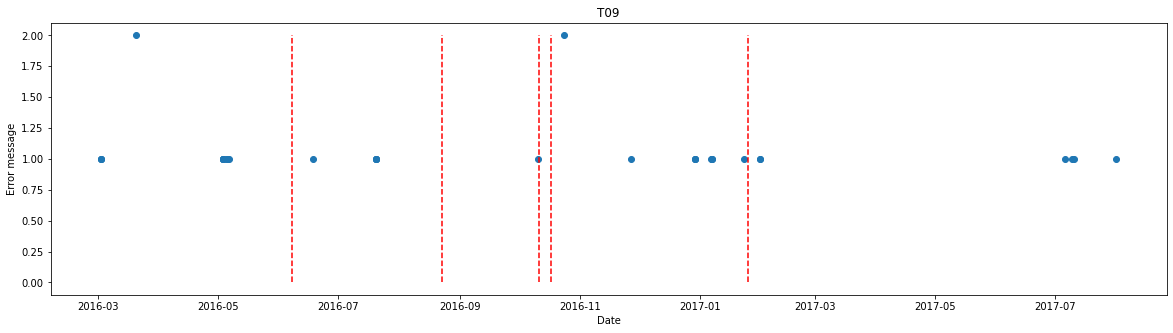

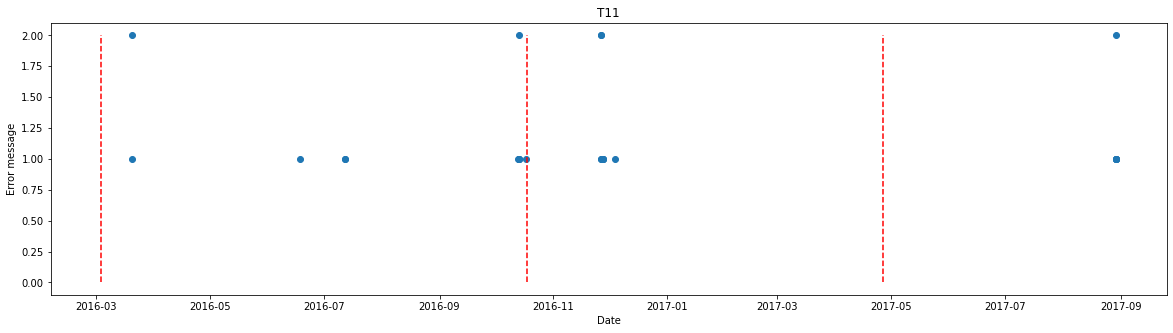

In [10]:
# Lets see there is evidence between the number of errors messages and failures
error = logs_df[logs_df['Remark'].str.contains('rror')]
temp = error.groupby(by=['UnitTitle', 'TimeDetected']).count().reset_index()
for turbine in turbines:
    plt.figure(figsize=(20,5)) 
    temp_ = temp[temp['UnitTitle']==turbine]
    failures_df_ = failures_df[failures_df['Turbine_ID']==turbine]
    plt.scatter(temp_['TimeDetected'], temp_['Remark'])
    plt.vlines(x=failures_df_['Timestamp'], color='red', linestyle= '--', ymin=0, ymax=max(temp_['Remark']))
    plt.title(turbine)
    plt.xlabel("Date")
    plt.ylabel("Error message")
    plt.show()

##### Again, we can't really see a clear relation between the error messages before a turbine failure. It should be interesting to know what logs are error logs, but we don't have an expert nearby

#### Since we don't have an expert to talk about the abnormal behaviour logs, we will try to do an analysis based on the data we have

In [11]:
# Let's try to see which kind of logs there is in the 60 days before a failure

logs_list = [logs_gen_train, logs_bear_train, logs_transf_train, logs_hyd_train, logs_gear_train]
logs_name = ['logs_gen_train', 'logs_bear_train', 'logs_transf_train', 'logs_hyd_train', 'logs_gear_train'] 

for logs, name in zip(logs_list, logs_name):
    # Filter for the 60 days before the failure
    message = logs[logs['Failure']==1]
    # Nº unique valures
    n_unique = message['Remark'].nunique()
    print(f'Nº of unique messages {name}: {n_unique}')
    # Most frequent 10 messages
    most_freq_mess = message['Remark'].value_counts()[0:10]
    print(f'Most Freq. messages {name}: \n{most_freq_mess}')

Nº of unique messages logs_gen_train: 864
Most Freq. messages logs_gen_train: 
External power ref.:2000kW       7370
Generator 1 in                   1432
Yaw Speed Exc:  0° Rate:10sec     384
GearoilCooler 1, gear:  49°C      317
GearoilCooler 2, gear:  57°C      316
Gen. ext. vent. 1, temp: 50°C     133
Gen. int. vent. 1, temp: 50°C     133
Gen. ext. vent. 0, temp: 34°C     126
Gen. int. vent. 0, temp: 34°C     126
HV Trafo. vent. 1, temp:  2°C     119
Name: Remark, dtype: int64
Nº of unique messages logs_bear_train: 1201
Most Freq. messages logs_bear_train: 
External power ref.:2000kW       8415
Generator 1 in                   2190
Yaw Speed Exc:  0° Rate:10sec     613
GearoilCooler 2, gear:  57°C      462
GearoilCooler 1, gear:  49°C      462
Gen. ext. vent. 2, temp: 65°C     186
Gen. ext. vent. 1, temp: 49°C     183
Gen. int. vent. 1, temp: 50°C     177
Gen. ext. vent. 1, temp: 50°C     177
Gen. int. vent. 0, temp: 34°C     167
Name: Remark, dtype: int64
Nº of unique messages log

In [12]:
# Compare with the overall logs

for logs, name in zip(logs_list, logs_name):
    # Nº unique valures
    n_unique = logs['Remark'].nunique()
    print(f'Nº of unique messages {name}: {n_unique}')
    # Most frequent 10 messages
    most_freq_mess = logs['Remark'].value_counts()[0:10]
    print(f'Most Freq. messages {name}: \n{most_freq_mess}')

Nº of unique messages logs_gen_train: 3619
Most Freq. messages logs_gen_train: 
External power ref.:2000kW       89896
Generator 1 in                   17433
Hot HV trafo 270°C      0kW      12554
Pause pressed on keyboard         5232
Yawing manually stopped           5038
GearoilCooler 2, gear:  57°C      4805
Start manual yawing CCW           4757
Yaw Speed Exc:  0° Rate:10sec     4499
GearoilCooler 1, gear:  49°C      4310
Run                               3792
Name: Remark, dtype: int64
Nº of unique messages logs_bear_train: 3619
Most Freq. messages logs_bear_train: 
External power ref.:2000kW       82547
Generator 1 in                   15939
Hot HV trafo 270°C      0kW      12554
GearoilCooler 2, gear:  57°C      4443
GearoilCooler 1, gear:  49°C      4359
Yaw Speed Exc:  0° Rate:10sec     4327
Gen. ext. vent. 2, temp: 65°C     1498
Gen. int. vent. 1, temp: 50°C     1493
Gen. ext. vent. 1, temp: 50°C     1492
Gen. ext. vent. 0, temp: 34°C     1429
Name: Remark, dtype: int64
Nº o

### EDA on GENERATOR

In [13]:
generator_train.head()

Turbine_ID       Date  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  Gen_RPM_Std  \
0        T01 2016-01-01  1258.952778   929.964583  1100.689583    92.588194   
1        T01 2016-01-02   699.955556   493.626389   603.794444    58.183333   
2        T01 2016-01-03   929.293750   756.286806   862.535417    40.109028   
3        T01 2016-01-04  1711.199306  1499.402083  1626.701389    39.796528   
4        T01 2016-01-05  1672.504167  1436.100000  1567.234028    49.702083   

   Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  \
0          39.354167            56.444444            56.430556   
1          34.076389            45.527778            45.312500   
2          42.791667            55.340278            53.944444   
3          65.291667            98.659722            94.847222   
4          56.298611            91.402778            88.159722   

   Gen_Phase3_Temp_Avg  ...  Cont_VCP_Temp_Avg_sd  Nac_Temp_Avg_sd  \
0            55.895833  ...              0.000000         0.000000   
1            44.847222  ...              2.558352         0.623629   
2            52.965278  ...              2.531003         0.728086   
3            93.381944  ...              3.215982         2.494331   
4            86.909722  ...              2.818498         2.169350   

   Nac_Direction_Avg_sd  Spin_Temp_Avg_sd  Prod_LatestAvg_TotActPwr_sd  \
0              0.000000          0.000000                     0.000000   
1             45.821993          1.433855                  9147.373934   
2             44.775715          1.251523                 33222.582951   
3             45.540714          1.022578                 86806.870980   
4             55.760338          1.387065                 84928.489634   

   Prod_LatestAvg_TotReactPwr_sd  Grd_InverterPhase1_Temp_Avg_sd  \
0                       0.000000                        0.000000   
1                    4101.135853                        2.641830   
2                    3680.338739                        1.998311   
3                   10096.957475                        3.155894   
4                   10359.072412                        2.782732   

   Grd_Busbar_Temp_Avg_sd  TTF  Failure  
0                0.000000  0.0        0  
1                3.353847  0.0        0  
2                3.045330  0.0        0  
3                4.936933  0.0        0  
4                4.519062  0.0        0  

[5 rows x 91 columns]

In [14]:
generator_train.describe()

Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  \
count  1822.000000  1822.000000  1822.000000  1822.000000        1822.000000   
mean   1163.781520   909.566837  1039.702759    68.153352          46.887986   
std     415.110918   400.998464   412.164658    26.392552          13.689701   
min       0.000000     0.000000     0.000000     0.000000          21.527778   
25%     835.025040   564.261979   699.039063    48.755903          37.239583   
50%    1185.346875   898.404861  1046.512847    65.744097          43.743056   
75%    1555.545660  1272.830729  1426.134896    84.022117          54.352431   
max    1792.761111  1614.880556  1680.684028   188.073611         205.000000   

       Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  \
count          1822.000000          1822.000000          1822.000000   
mean             63.168338            62.993075            62.501560   
std              22.719275            22.030429            21.513542   
min              24.201389            24.173611            24.083333   
25%              46.918403            47.279514            46.984082   
50%              55.552083            55.663194            55.493056   
75%              75.350694            75.105903            74.520833   
max             205.000000           205.000000           205.000000   

       Gen_SlipRing_Temp_Avg  Gen_Bear2_Temp_Avg  ...  Cont_VCP_Temp_Avg_sd  \
count            1822.000000         1822.000000  ...           1822.000000   
mean               29.547744           43.059864  ...              3.474460   
std                 7.632075           11.832189  ...              0.636374   
min                17.166667           22.673611  ...              0.000000   
25%                23.710728           34.741319  ...              3.036157   
50%                28.399306           40.562500  ...              3.515456   
75%                33.611111           49.376736  ...              3.860970   
max                92.400000          205.000000  ...              5.239366   

       Nac_Temp_Avg_sd  Nac_Direction_Avg_sd  Spin_Temp_Avg_sd  \
count      1822.000000           1822.000000       1822.000000   
mean          2.784901             69.139652          2.211405   
std           0.696921             10.408724          0.611330   
min           0.000000              0.000000          0.000000   
25%           2.282827             65.957771          1.683141   
50%           2.745987             69.990834          2.228447   
75%           3.259560             75.716869          2.708947   
max           4.523134             86.626533          3.693722   

       Prod_LatestAvg_TotActPwr_sd  Prod_LatestAvg_TotReactPwr_sd  \
count                  1822.000000                    1822.000000   
mean                  81849.861893                    9590.435124   
std                   13817.963439                    1273.290101   
min                       0.000000                       0.000000   
25%                   75199.199680                    8865.474320   
50%                   82094.681633                    9622.443164   
75%                   87781.222463                   10370.580014   
max                  119773.671408                   12802.820253   

       Grd_InverterPhase1_Temp_Avg_sd  Grd_Busbar_Temp_Avg_sd          TTF  \
count                     1822.000000             1822.000000  1822.000000   
mean                         3.389427                5.232794    12.091109   
std                          0.553557                0.926060    34.982139   
min                          0.000000                0.000000     0.000000   
25%                          3.015885                4.602494     0.000000   
50%                          3.441546                5.240343     0.000000   
75%                          3.767868                5.839778     0.000000   
max                          4.695784                7.648684   192.000000   

     

In [15]:
# Original Features Generator (without data augmentation)
or_feat_gen = ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 
               'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gen_SlipRing_Temp_Avg',
               'Gen_Bear2_Temp_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 
               'Amb_Temp_Avg', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Avg',
               'Blds_PitchAngle_Std', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Nac_Temp_Avg', 
               'Nac_Direction_Avg', 'Spin_Temp_Avg', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_TotReactPwr',
               'Grd_InverterPhase1_Temp_Avg', 'Grd_Busbar_Temp_Avg']

In [16]:
# get ordered list of top variance features:
features_top_var = generator_train[or_feat_gen].std().sort_values(ascending=False)
features_top_var

Prod_LatestAvg_TotActPwr       85141.177614
Prod_LatestAvg_TotReactPwr      9847.746746
Gen_RPM_Max                      415.110918
Gen_RPM_Avg                      412.164658
Gen_RPM_Min                      400.998464
Nac_Direction_Avg                 75.666265
Gen_RPM_Std                       26.392552
Gen_Phase1_Temp_Avg               22.719275
Gen_Phase2_Temp_Avg               22.030429
Gen_Phase3_Temp_Avg               21.513542
Gen_Bear_Temp_Avg                 13.689701
Gen_Bear2_Temp_Avg                11.832189
Blds_PitchAngle_Max               10.952018
Blds_PitchAngle_Avg               10.884493
Blds_PitchAngle_Min               10.568626
Gen_SlipRing_Temp_Avg              7.632075
Grd_Busbar_Temp_Avg                6.328385
Amb_WindSpeed_Max                  5.258463
Amb_Temp_Avg                       4.948115
Spin_Temp_Avg                      4.832738
Nac_Temp_Avg                       4.790363
Cont_Top_Temp_Avg                  4.773033
Cont_VCP_Temp_Avg               

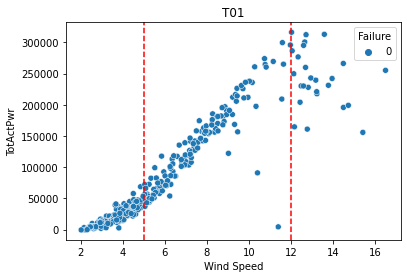

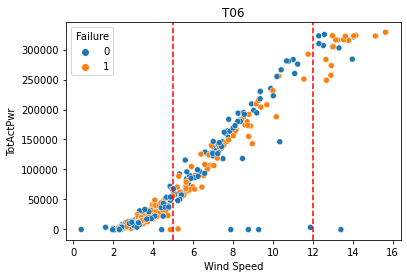

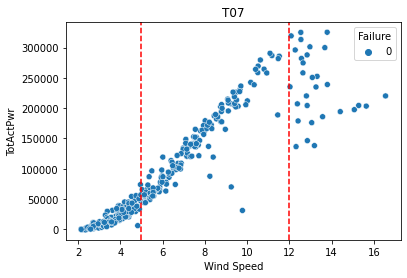

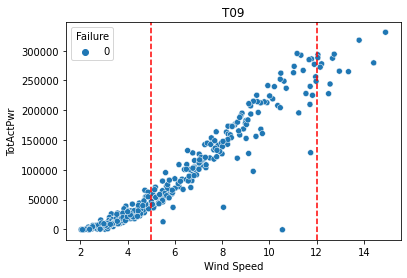

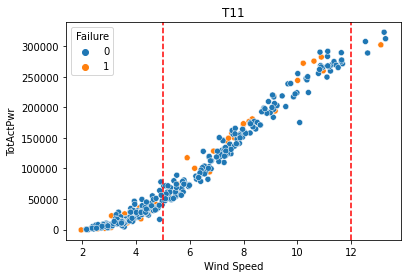

In [17]:
# See if there is an abnormal behaviour 60 days before the failure
#Plot behaviour for all turbines
turbines = ['T01', 'T06', 'T07', 'T09', 'T11']
for turbine in turbines:
    temp = generator_train[generator_train['Turbine_ID']==turbine]
    sns.scatterplot(x=temp['Amb_WindSpeed_Avg'], y=temp['Prod_LatestAvg_TotActPwr'], hue=temp['Failure'])
    plt.title(turbine)
    plt.xlabel("Wind Speed")
    plt.ylabel("TotActPwr")
    plt.axvline(x=5, color='red', linestyle= '--')
    plt.axvline(x=12, color='red', linestyle= '--')
    plt.show()

##### It is actually a little counter intuitive since we would expect a failure in turbine 1, 7 and 9, by the plots comparing with the normal behaviour (graph from "1st" notebook)

### Plot features against Date, from a turbine with and without failures

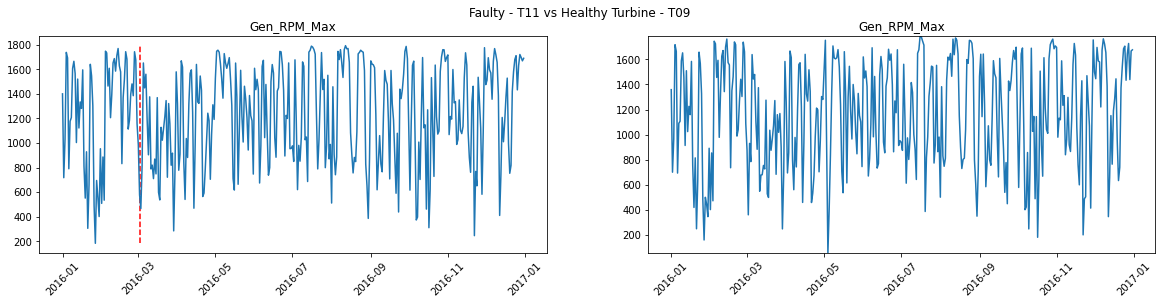

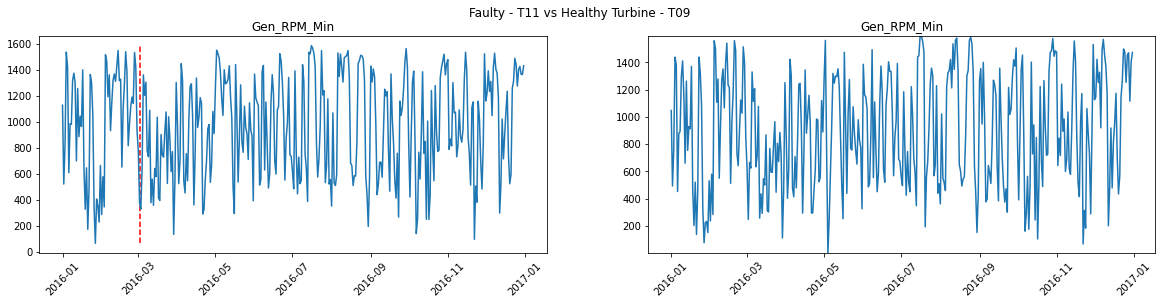

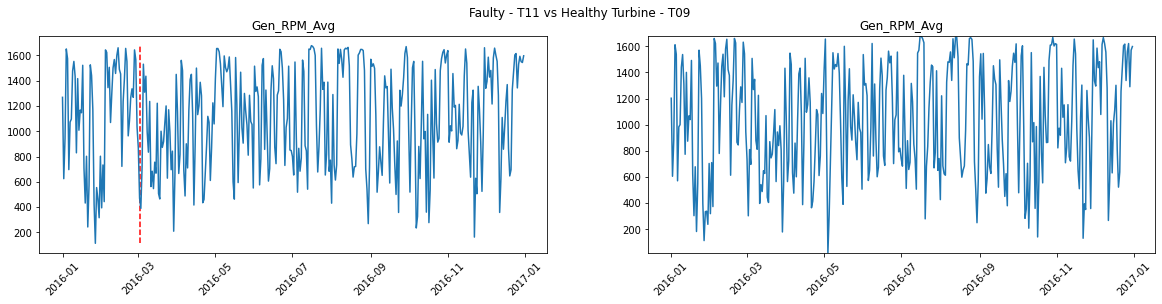

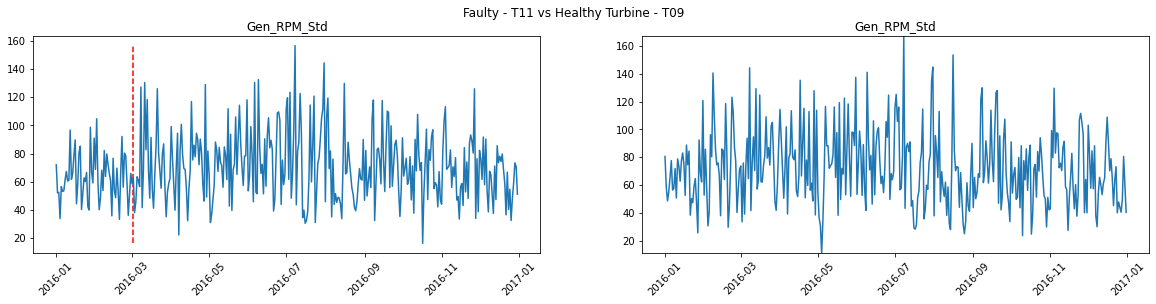

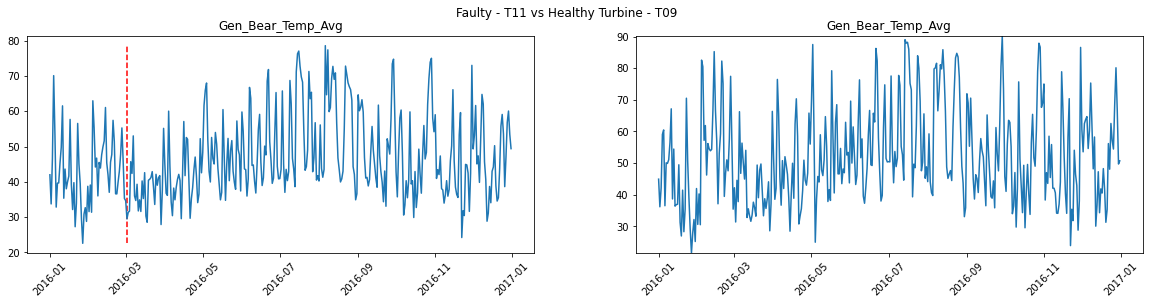

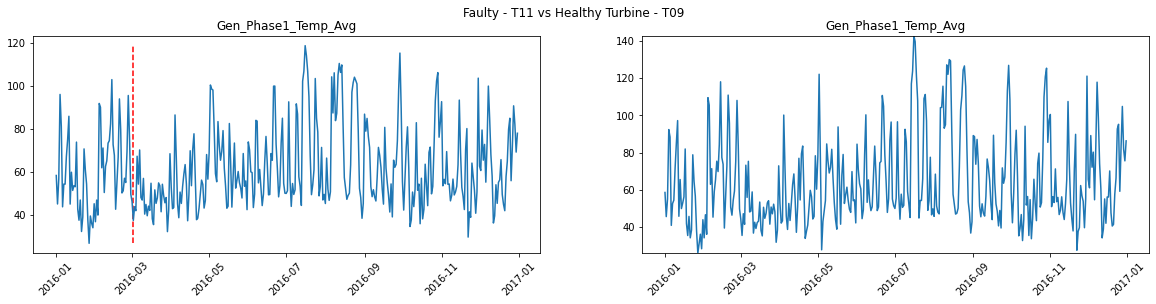

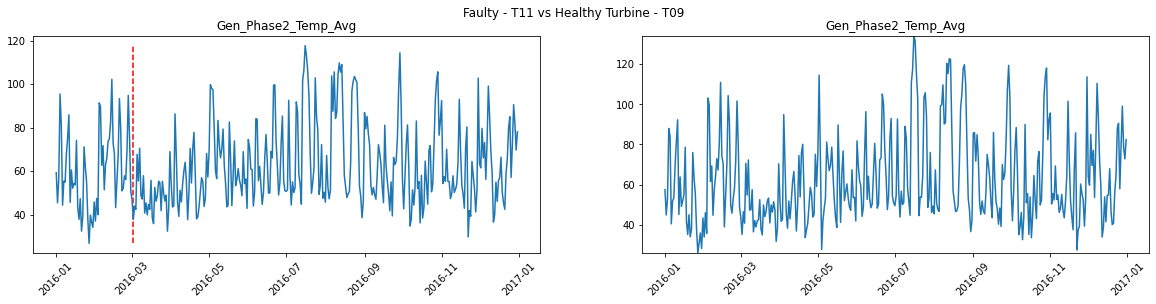

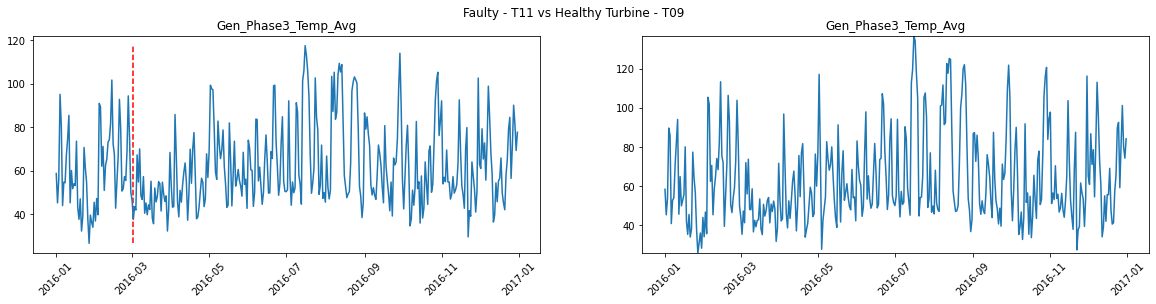

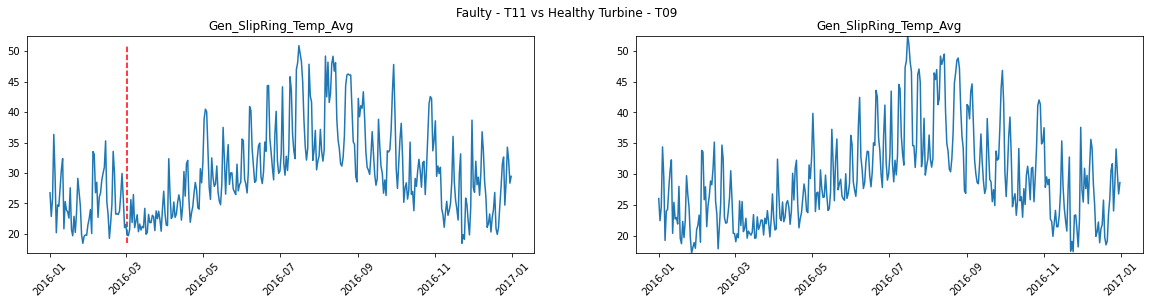

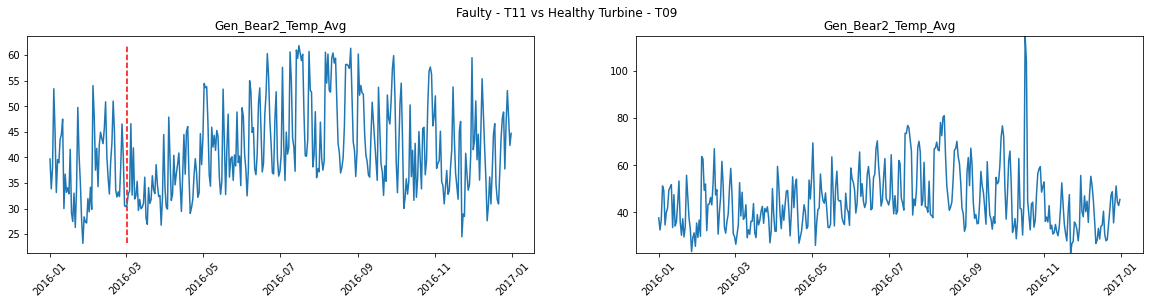

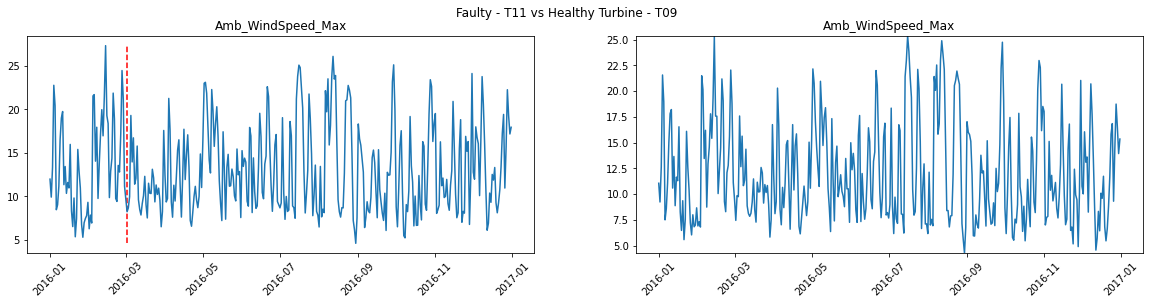

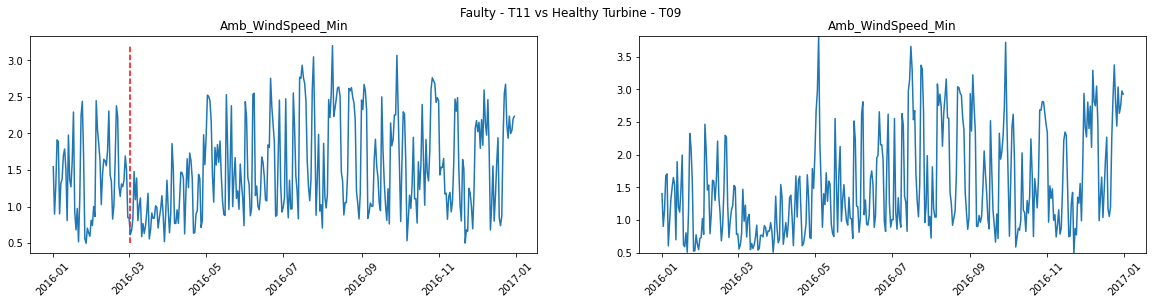

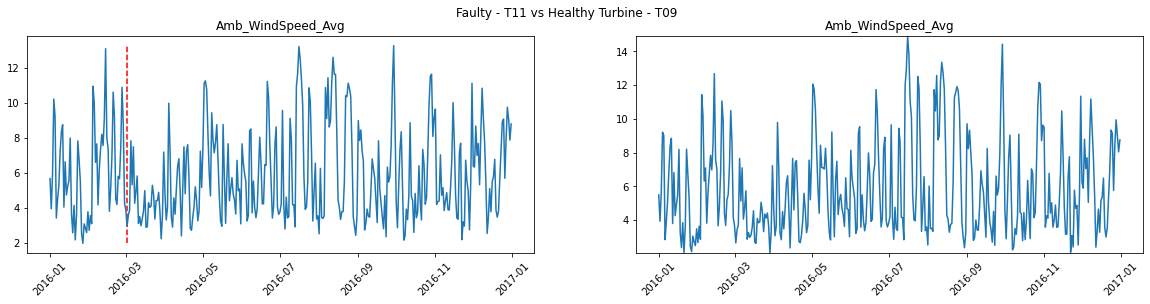

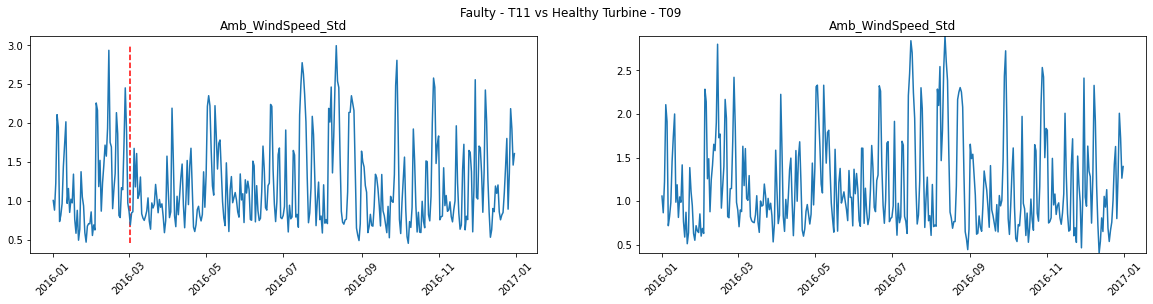

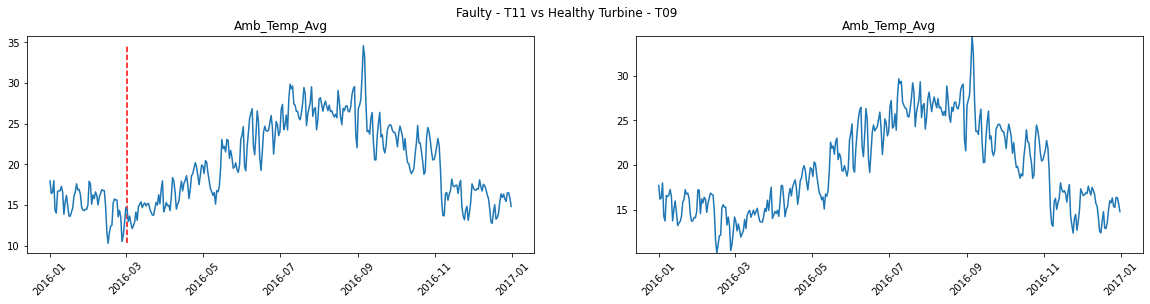

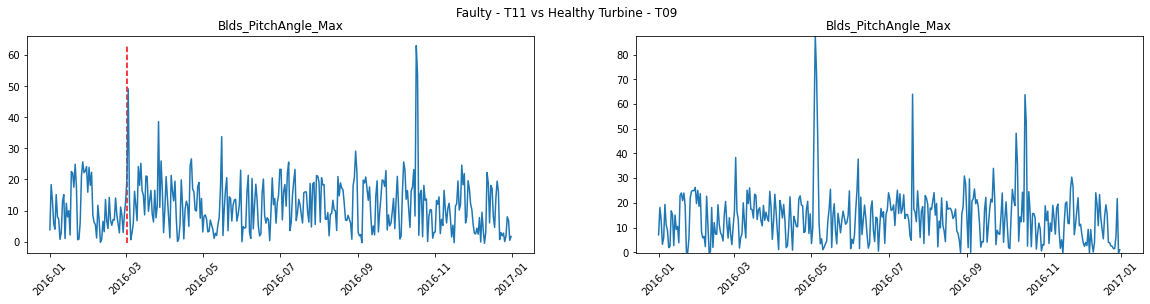

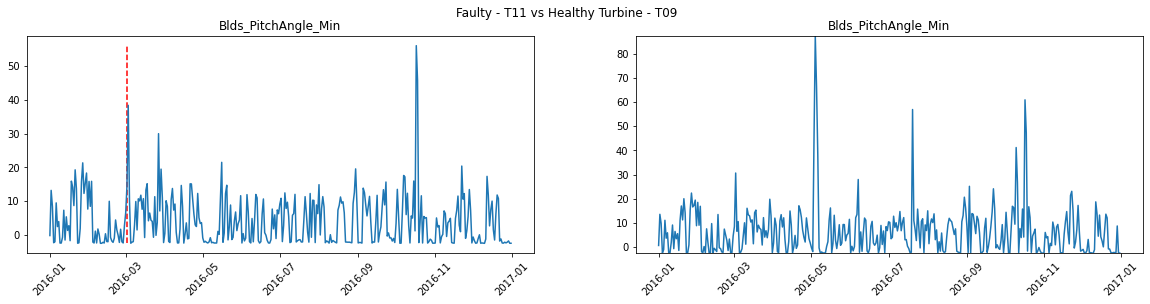

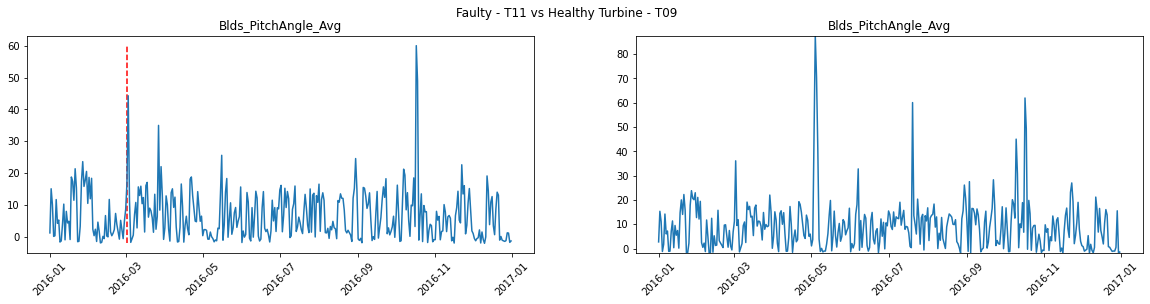

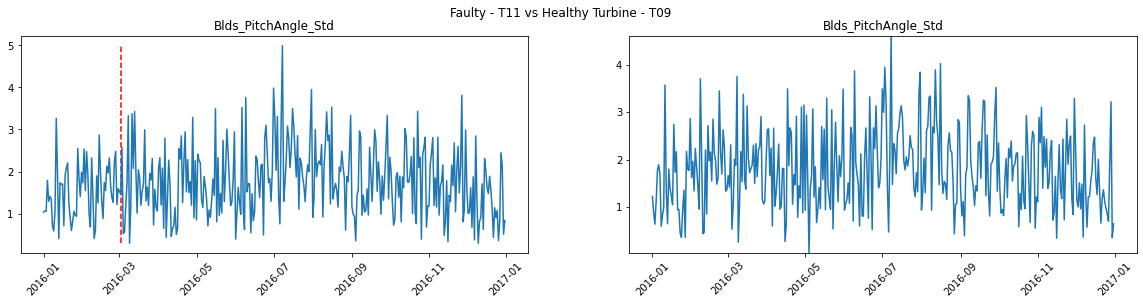

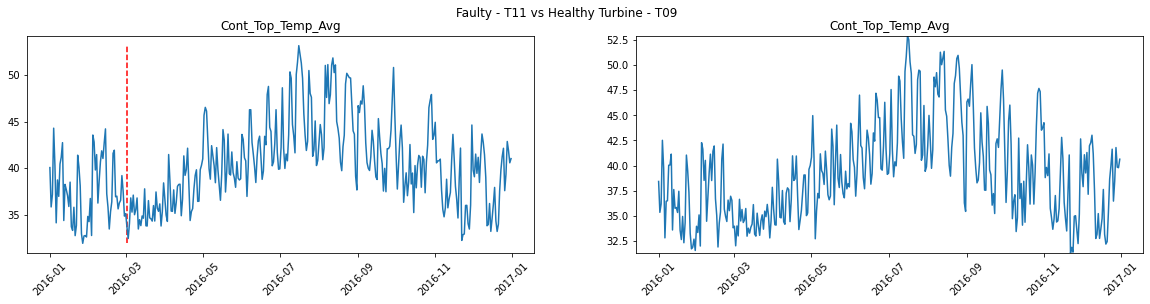

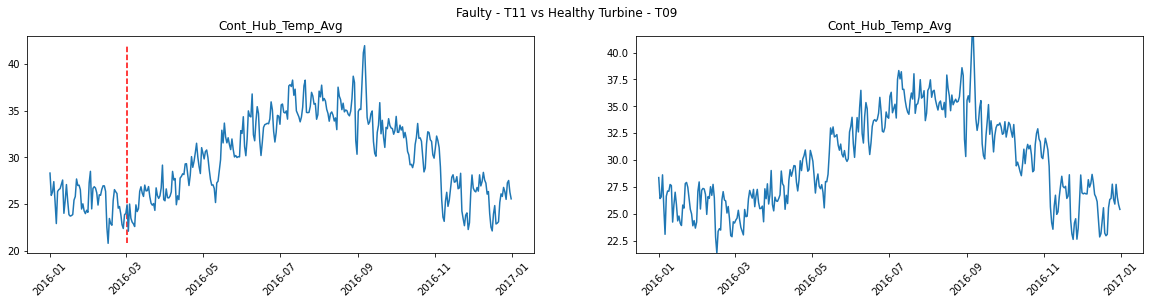

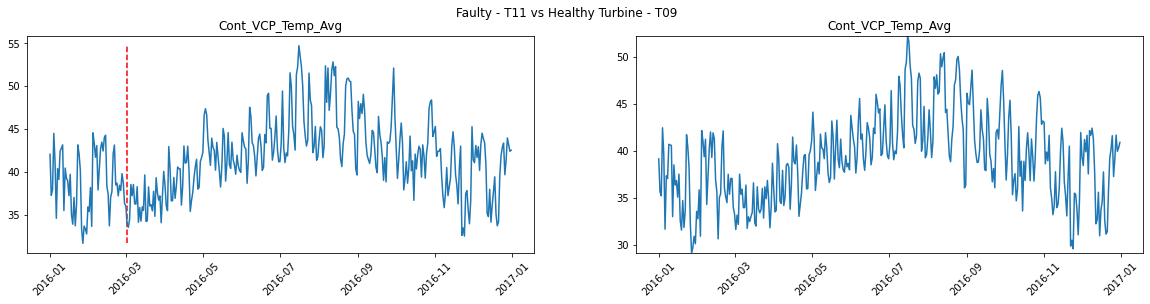

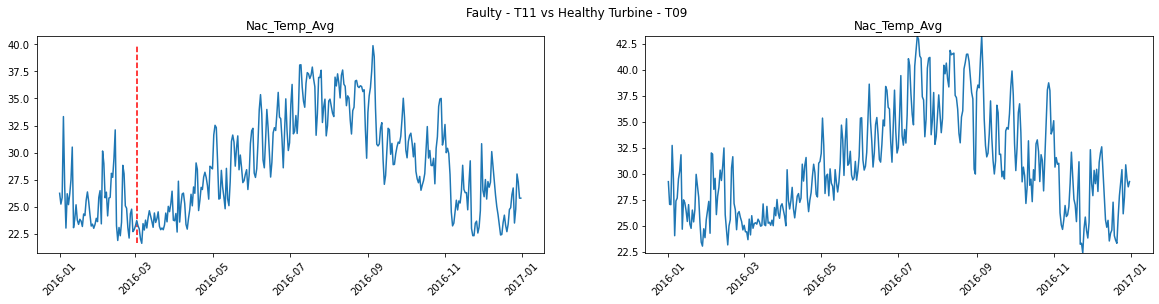

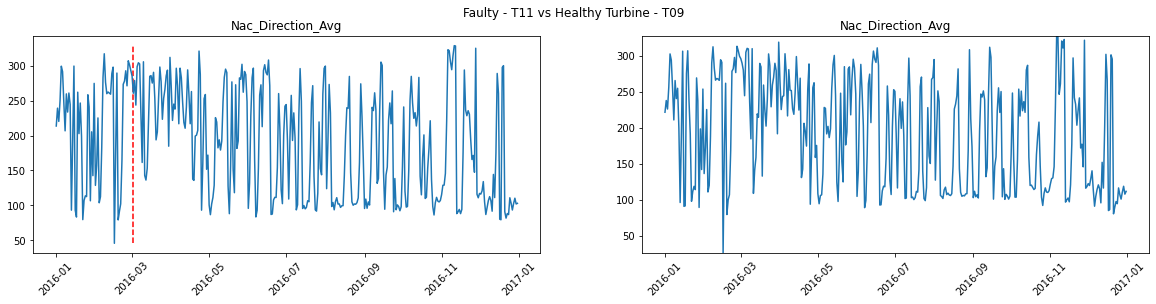

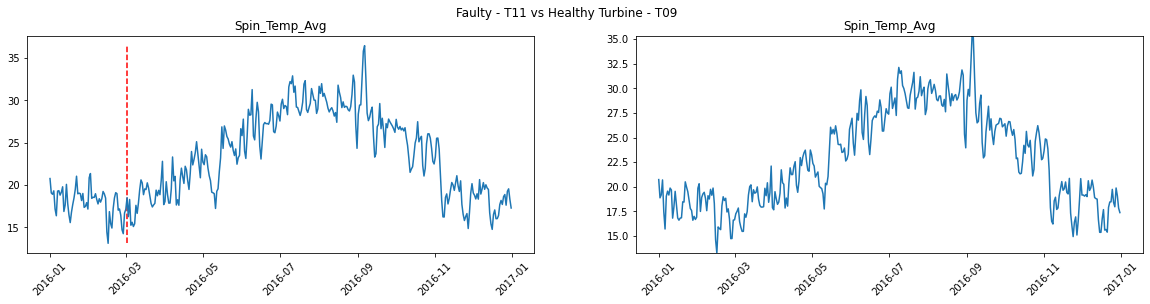

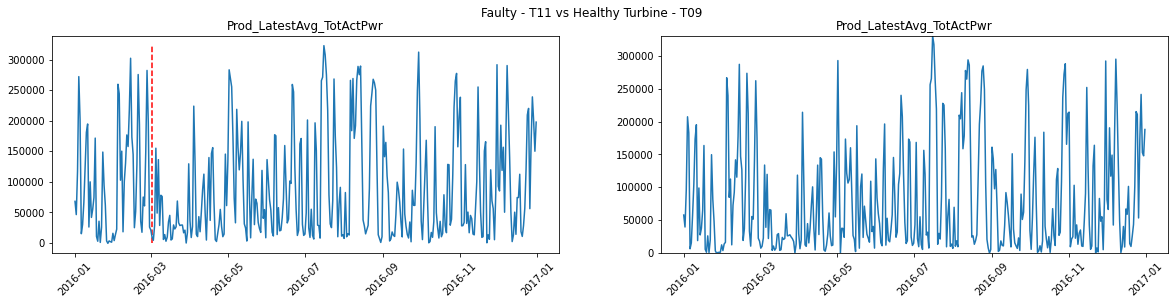

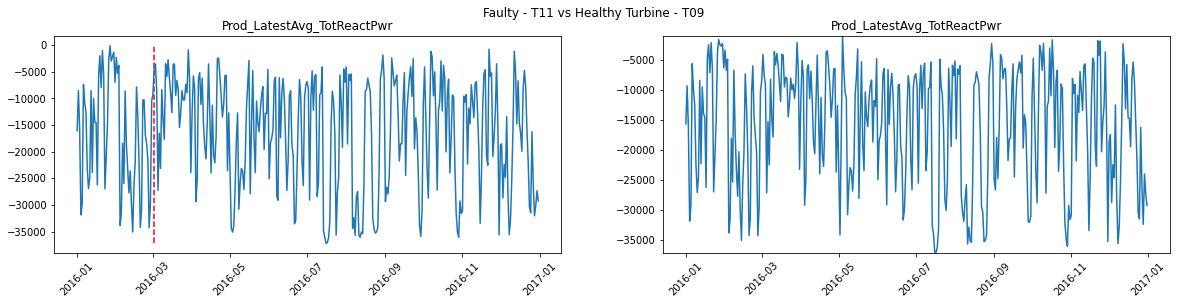

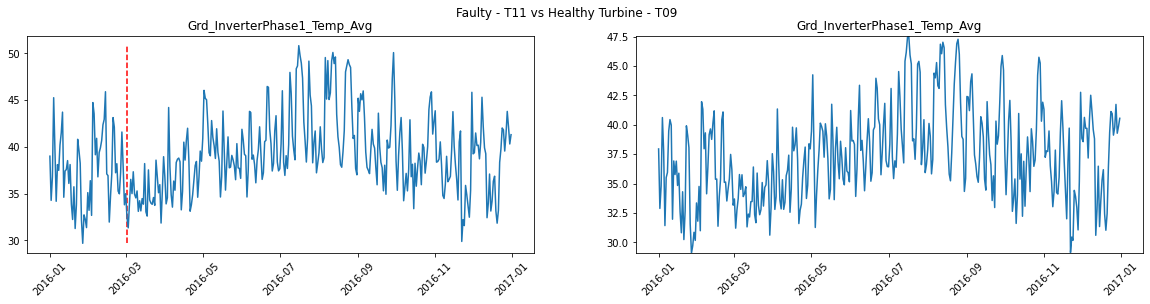

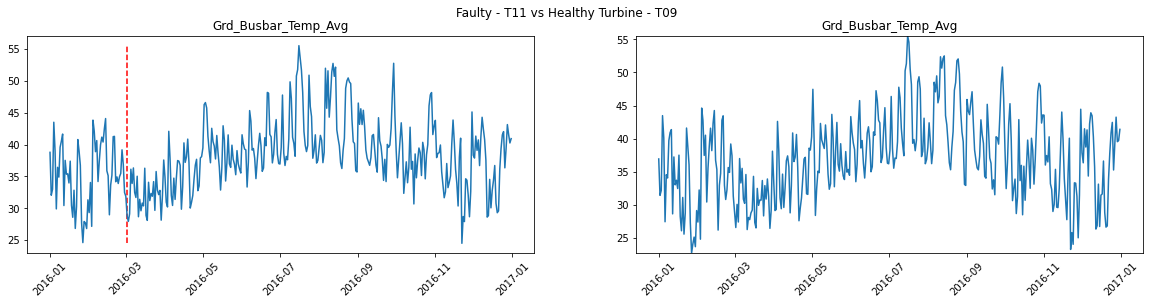

In [20]:
features = ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 
            'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gen_SlipRing_Temp_Avg',
            'Gen_Bear2_Temp_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 
            'Amb_Temp_Avg', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Avg',
            'Blds_PitchAngle_Std', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Nac_Temp_Avg', 
            'Nac_Direction_Avg', 'Spin_Temp_Avg', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_TotReactPwr',
            'Grd_InverterPhase1_Temp_Avg', 'Grd_Busbar_Temp_Avg']

# Faulty turbine
turbine_fail_gen = generator_train[generator_train['Turbine_ID']=='T11']
time_failure = generator_train[(generator_train['TTF']==1) & (generator_train['Turbine_ID']=='T11')]
# Healthy Turbine
turbine_gen = generator_train[generator_train['Turbine_ID']=='T09']

for feature in features:
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.plot(turbine_fail_gen['Date'], turbine_fail_gen[feature])
    plt.vlines(x=time_failure['Date'], color='red', linestyle= '--', ymin=min(turbine_fail_gen[feature]), ymax=max(turbine_fail_gen[feature]))
    plt.xticks(rotation=45)
    plt.title(feature)
    
    plt.subplot(1, 2, 2)
    plt.plot(turbine_gen['Date'], turbine_gen[feature])
    plt.ylim(min(turbine_gen[feature]), max(turbine_gen[feature])) # To have the same scale on both graphs - easy comparison
    plt.xticks(rotation=45)
    plt.title(feature)    
    
    plt.suptitle("Faulty - T11 vs Healthy Turbine - T09")
    plt.show()
    

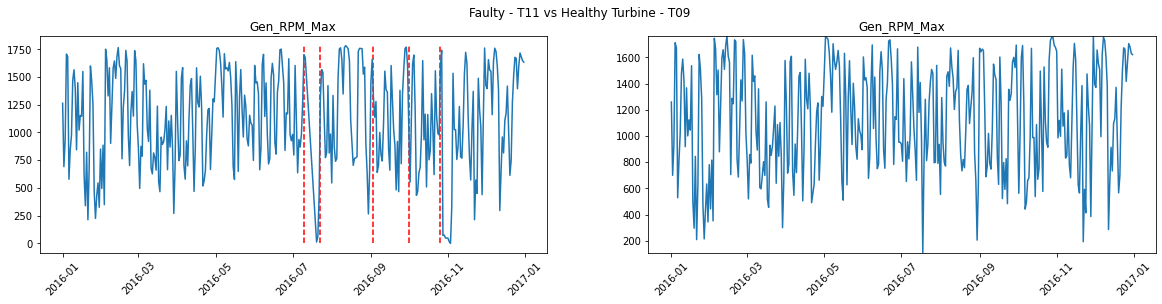

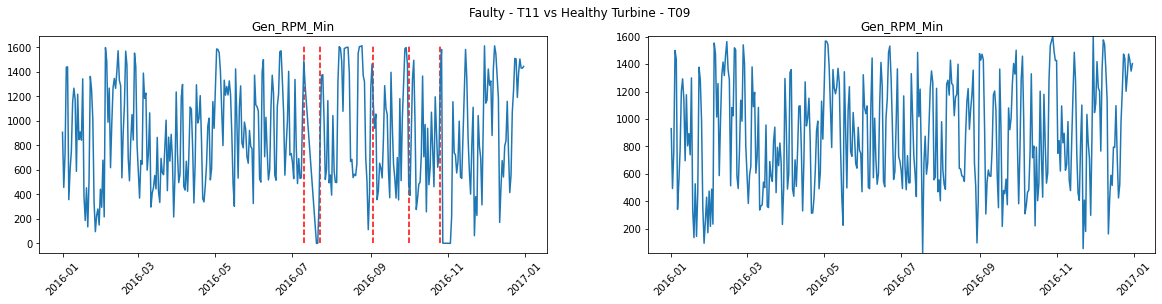

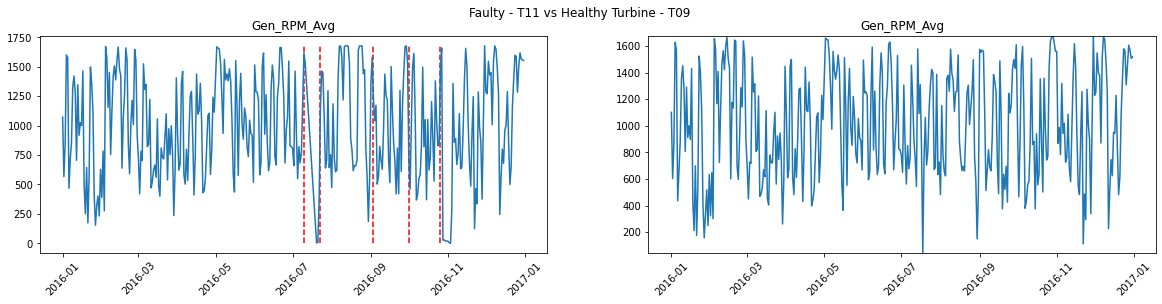

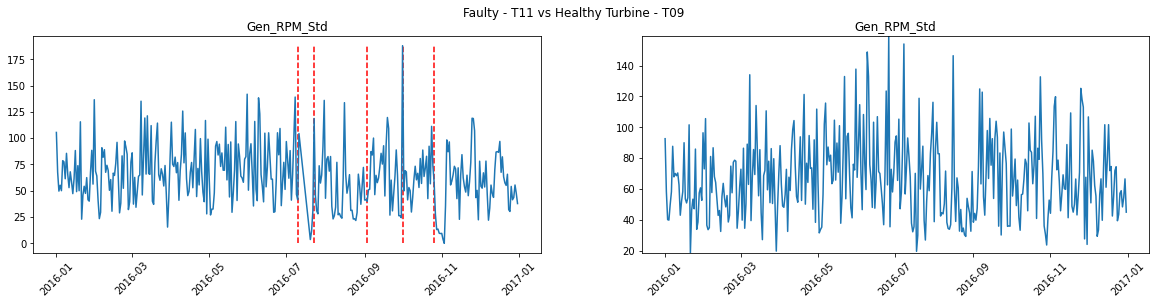

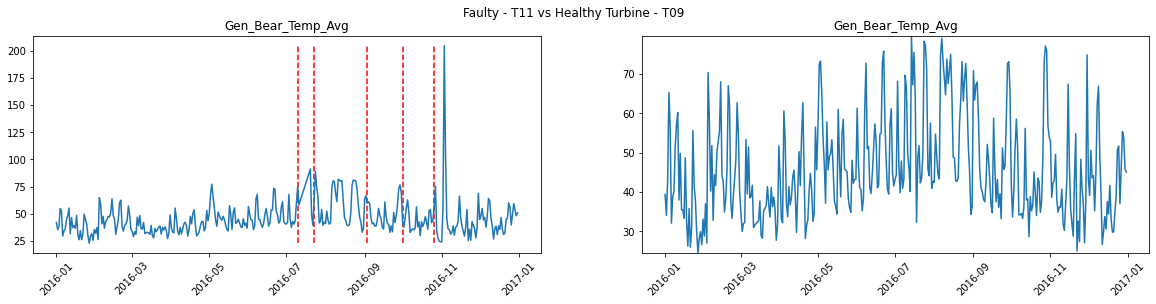

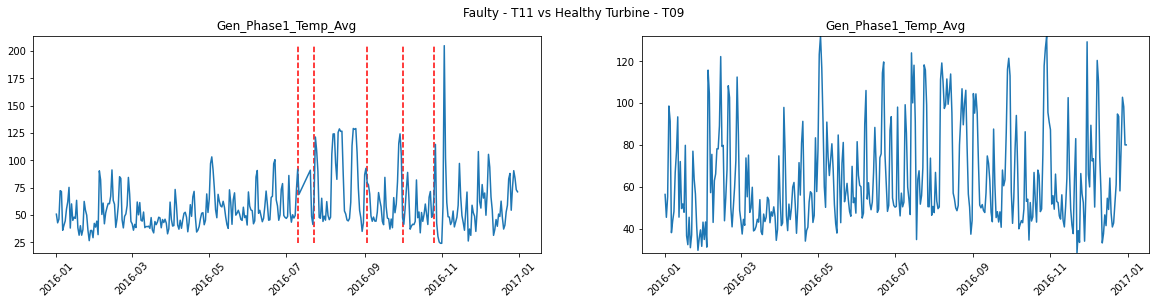

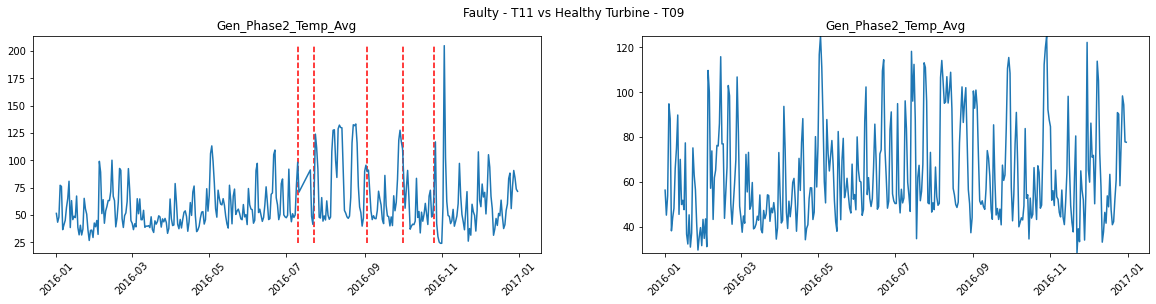

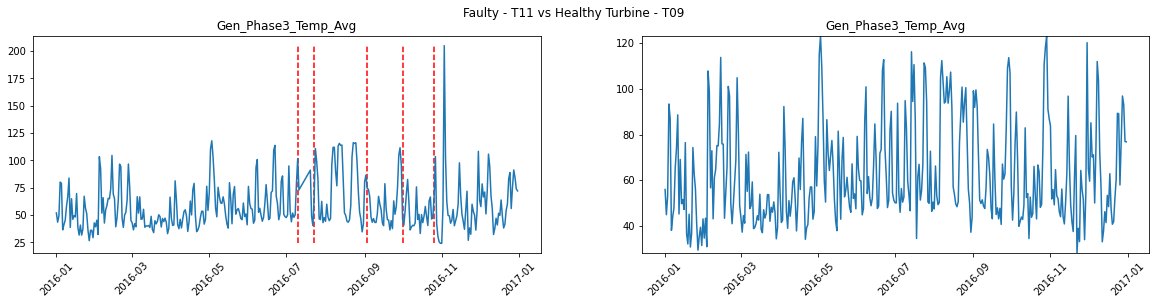

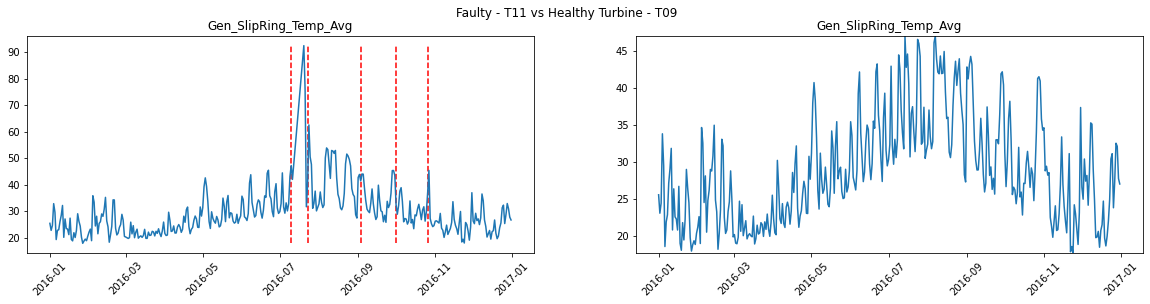

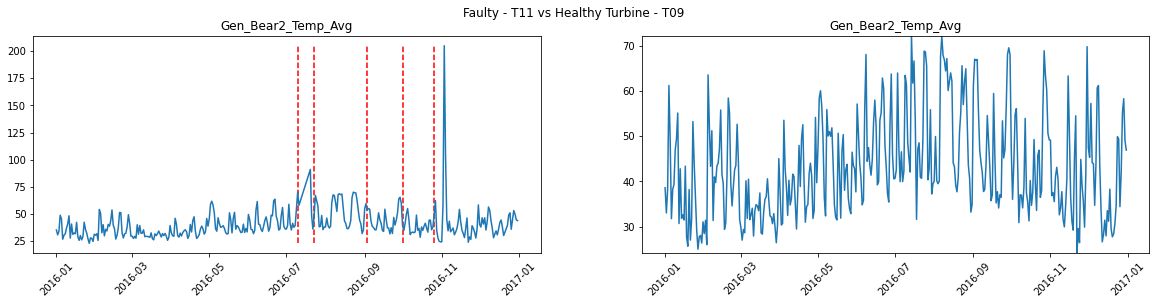

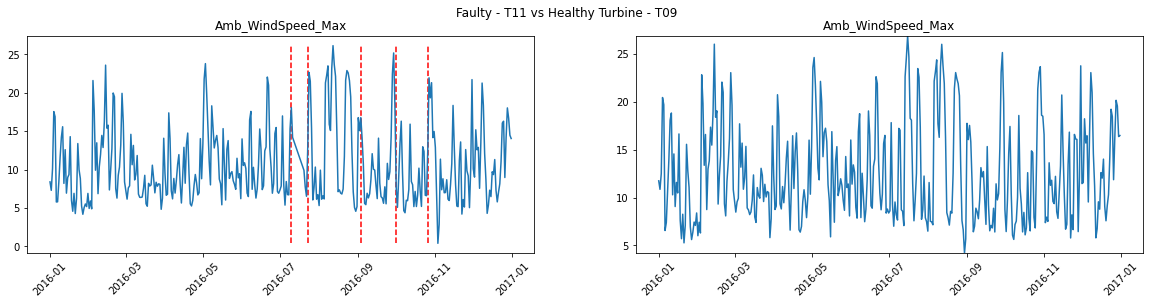

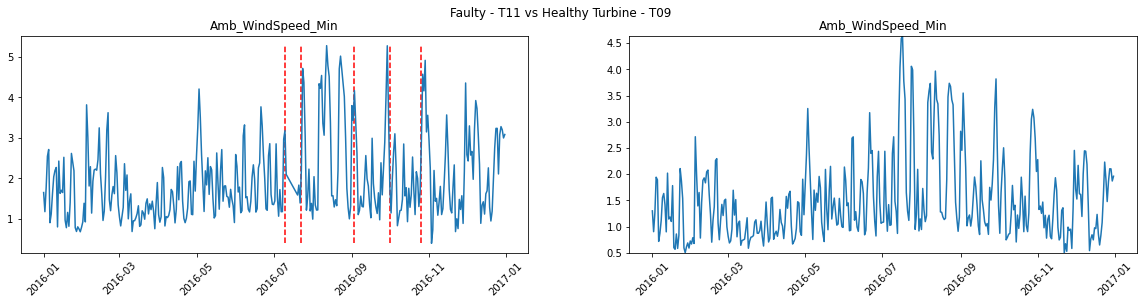

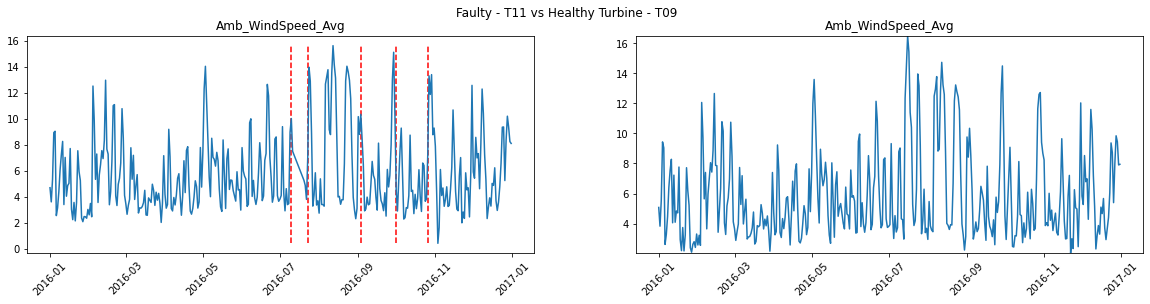

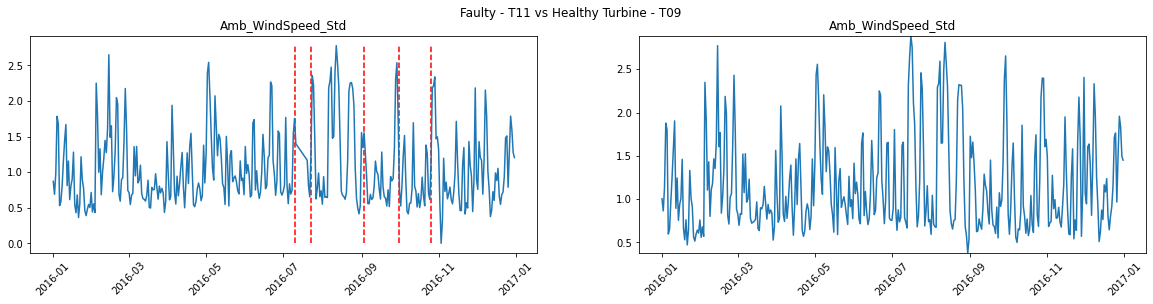

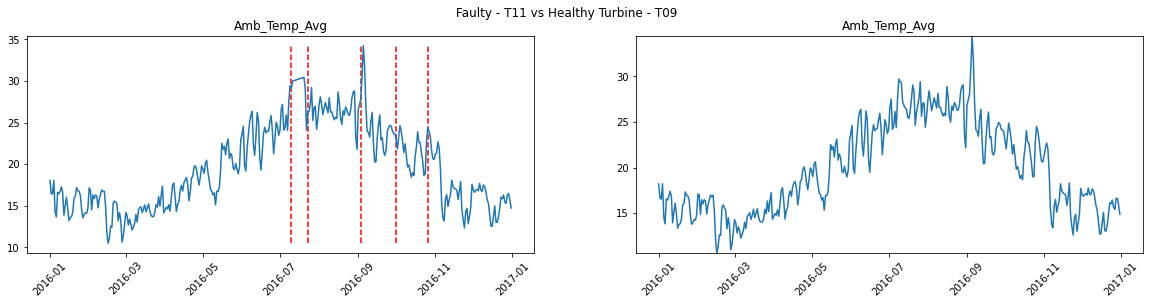

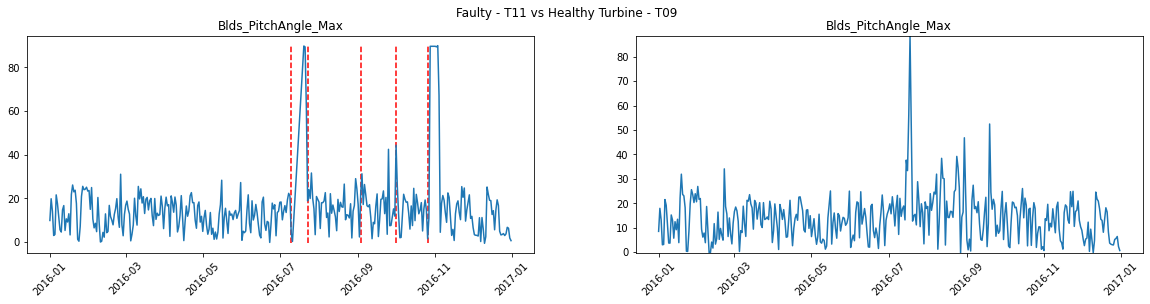

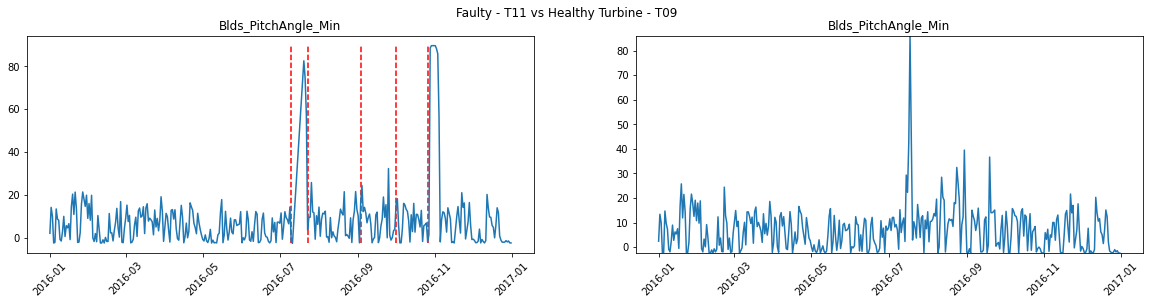

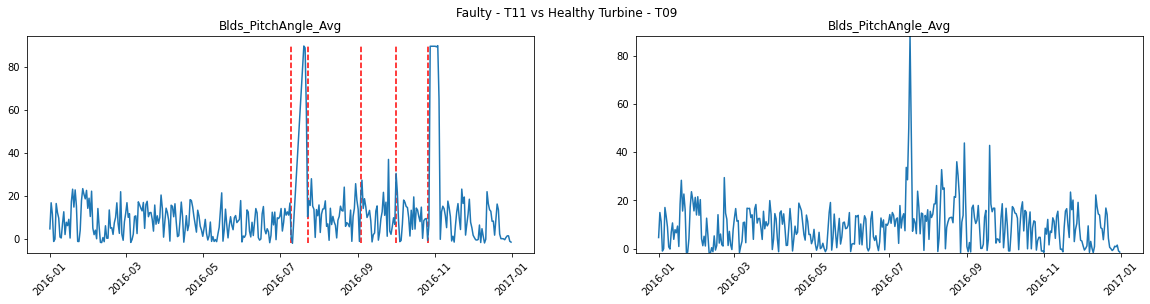

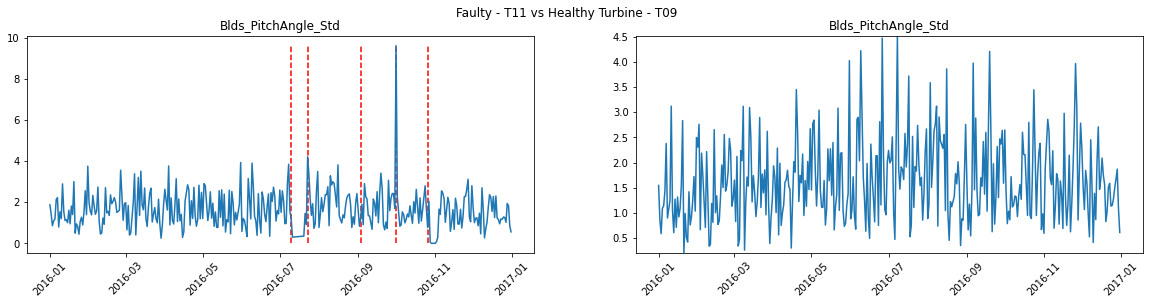

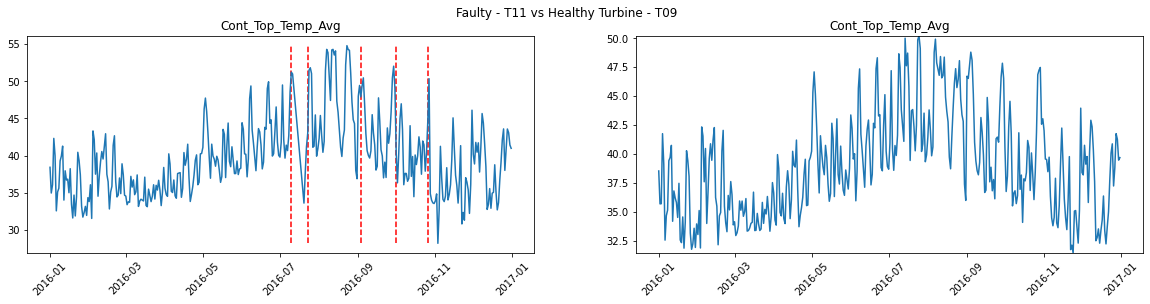

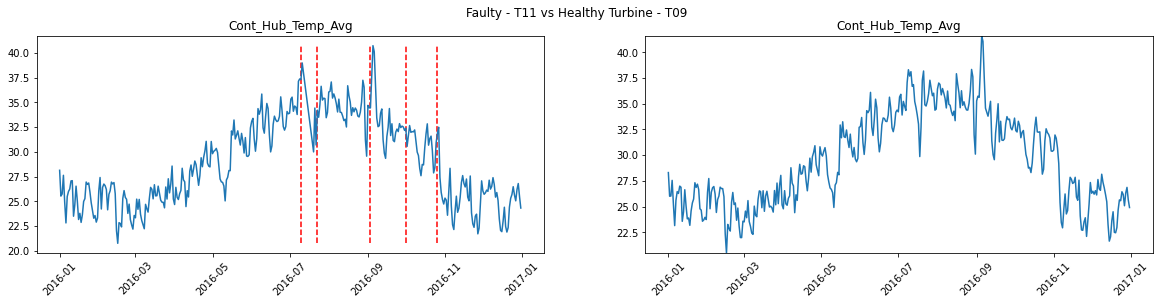

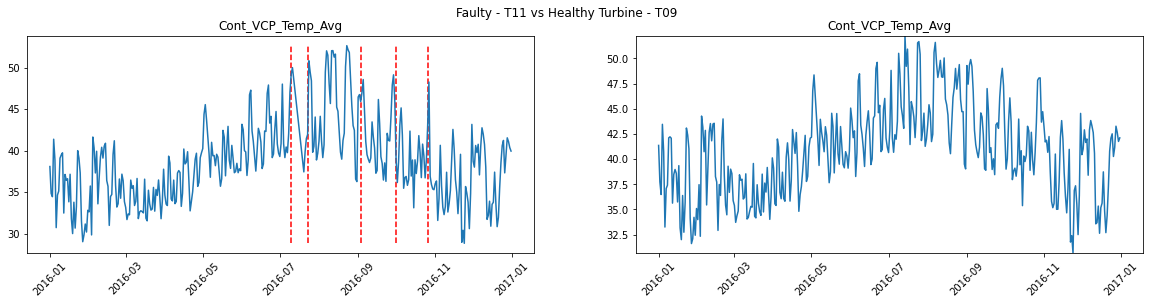

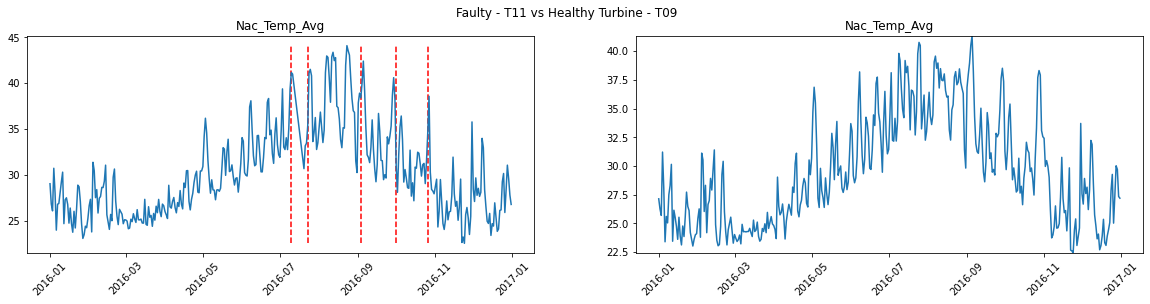

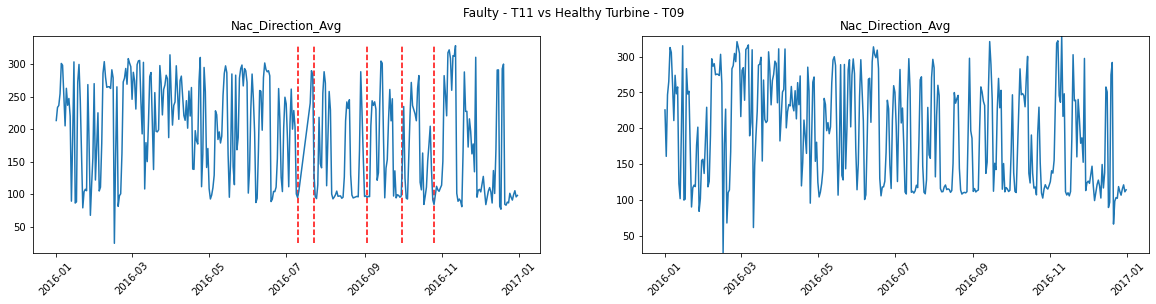

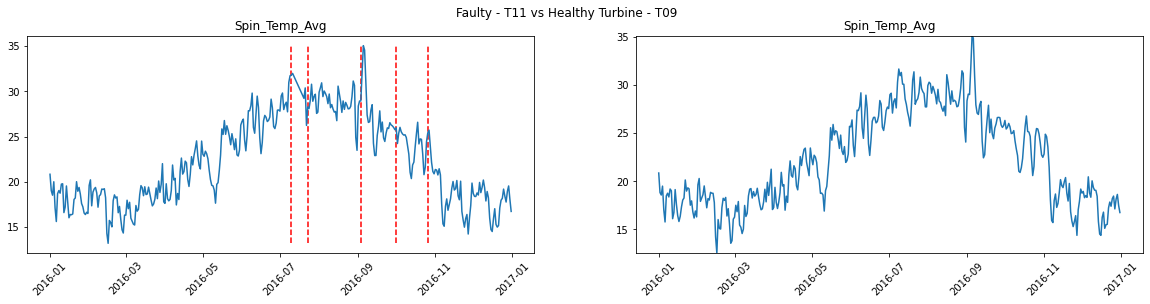

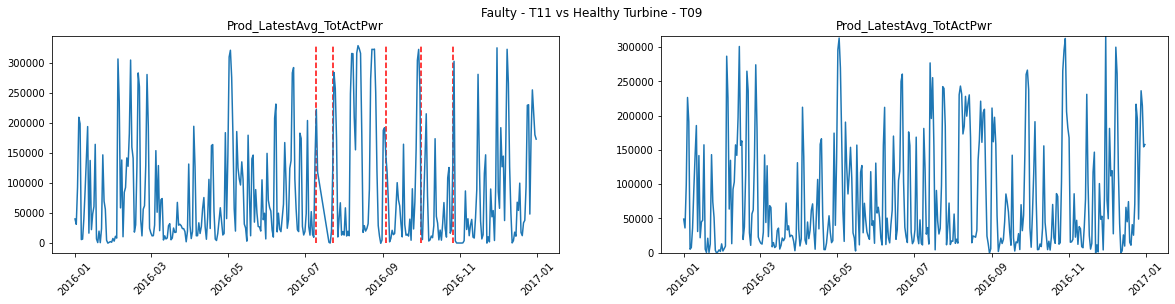

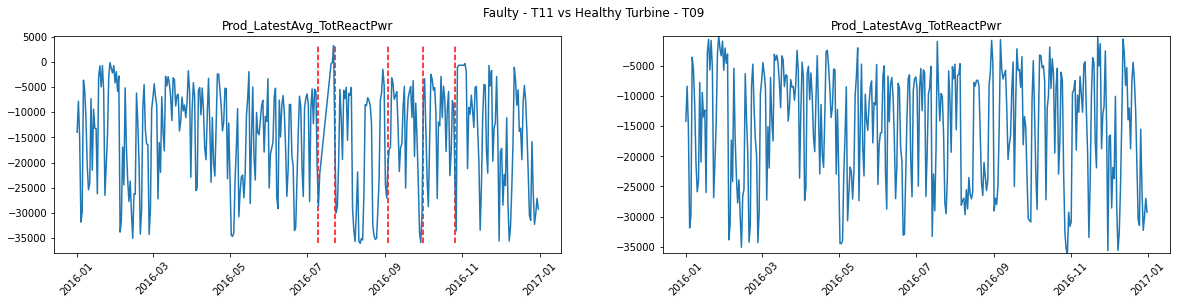

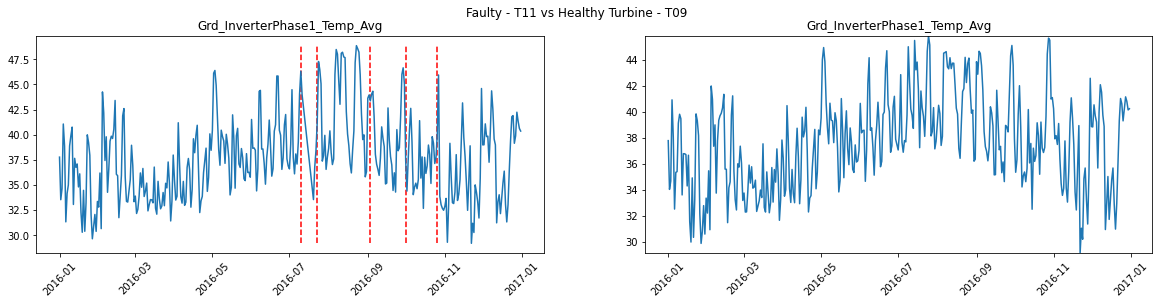

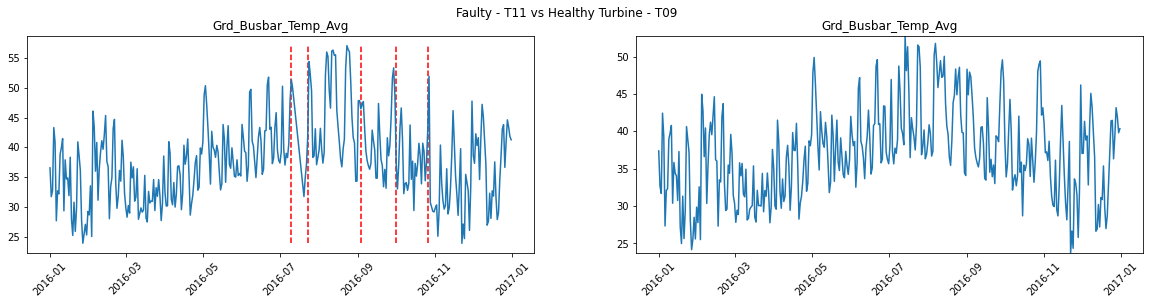

In [21]:
# Others Turbines
# Faulty turbine
turbine_fail_gen = generator_train[generator_train['Turbine_ID']=='T06']
time_failure = generator_train[(generator_train['TTF']==1) & (generator_train['Turbine_ID']=='T06')]
# Healthy Turbine
turbine_gen = generator_train[generator_train['Turbine_ID']=='T01']

for feature in features:
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.plot(turbine_fail_gen['Date'], turbine_fail_gen[feature])
    plt.vlines(x=time_failure['Date'], color='red', linestyle= '--', ymin=min(turbine_fail_gen[feature]), ymax=max(turbine_fail_gen[feature]))
    plt.xticks(rotation=45)
    plt.title(feature)
    
    plt.subplot(1, 2, 2)
    plt.plot(turbine_gen['Date'], turbine_gen[feature])
    plt.ylim(min(turbine_gen[feature]), max(turbine_gen[feature])) # To have the same scale on both graphs - easy comparison
    plt.xticks(rotation=45)
    plt.title(feature)    
    
    plt.suptitle("Faulty - T11 vs Healthy Turbine - T09")
    plt.show()